In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

from loguru import logger
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

### Model maken en trainen

In [2]:
try:
    logger.info("Data inladen")
    
    conn = sqlite3.connect('../data/processed/adventureworks.sqlite')
    test_db = sqlite3.connect('../data/processed/forecast_test.sqlite')

    order_header = pd.read_sql('SELECT * FROM "Sales.SalesOrderHeader"', conn)
    order_details = pd.read_sql('SELECT * FROM "Sales.SalesOrderDetail"', conn)
    orders = pd.merge(order_header, order_details, on='SalesOrderID')
    orders.to_sql('orders', test_db, if_exists='replace', index=False)

    logger.success("Data ingeladen")
    logger.info("Dataset maken")

    total_purchase = orders.groupby('CustomerID')['TotalDue'].sum()
    total_purchase.to_sql('total_purchase', test_db, if_exists='replace', index=True)

    frequency = orders.groupby('CustomerID')['SalesOrderID'].count()
    frequency.to_sql('frequency', test_db, if_exists='replace', index=True)

    recency = orders.groupby('CustomerID')['OrderDate'].max()
    recency = pd.to_datetime(recency)
    recency = pd.to_datetime('2014-07-01') - recency
    recency = recency.dt.days
    recency.to_sql('recency', test_db, if_exists='replace', index=True)

    churn = (
        (total_purchase < 125.90) |  # Klanten die minder dan het 25e percentiel uitgeven
    (frequency < 2) |  # Klanten die minder dan het 25e percentiel van aankopen doen
    (recency > 264) |  # Klanten die langer dan het 75e percentiel inactief zijn
        (np.random.rand(len(total_purchase)) < 0.1)  # 10% van de klanten die willekeurig worden geselecteerd
    ).astype(int).rename('Churn')
    churn.to_sql('churn', test_db, if_exists='replace', index=True)

    data = pd.merge(total_purchase, frequency, on='CustomerID').rename(columns={'TotalDue': 'TotalPurchase', 'SalesOrderID': 'Frequency'})
    data = pd.merge(data, recency, on='CustomerID').rename(columns={'OrderDate': 'Recency'})
    data = pd.merge(data, churn, on='CustomerID')

    data.to_sql('data', test_db, if_exists='replace', index=True)

    logger.success("Dataset gemaakt")
    logger.info("Data voorbereiden")

    X = data[['TotalPurchase', 'Frequency', 'Recency']]
    y = data['Churn']

    logger.success("Data voorbereid")
    logger.info("Data opsplitsen")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train.to_sql('X_train', test_db, if_exists='replace', index=True)
    X_test.to_sql('X_test', test_db, if_exists='replace', index=True)
    y_train.to_sql('y_train', test_db, if_exists='replace', index=True)
    y_test.to_sql('y_test', test_db, if_exists='replace', index=True)

    logger.success("Data opgesplitst")
    logger.info("Model maken en trainen")

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    logger.success("Model gemaakt en getraind")
    logger.info("Voorspellingen maken")

    y_pred = model.predict(X_test)

    logger.success("Voorspellingen gemaakt")
except Exception as e:
    logger.error(f"Error: {e}")

2024-05-24 18:19:32.708 | INFO     | __main__:<module>:2 - Data inladen
2024-05-24 18:19:34.424 | SUCCESS  | __main__:<module>:12 - Data ingeladen
2024-05-24 18:19:34.424 | INFO     | __main__:<module>:13 - Dataset maken
2024-05-24 18:19:35.474 | SUCCESS  | __main__:<module>:41 - Dataset gemaakt
2024-05-24 18:19:35.474 | INFO     | __main__:<module>:42 - Data voorbereiden
2024-05-24 18:19:35.474 | SUCCESS  | __main__:<module>:47 - Data voorbereid
2024-05-24 18:19:35.474 | INFO     | __main__:<module>:48 - Data opsplitsen
2024-05-24 18:19:35.608 | SUCCESS  | __main__:<module>:57 - Data opgesplitst
2024-05-24 18:19:35.608 | INFO     | __main__:<module>:58 - Model maken en trainen
2024-05-24 18:19:36.829 | SUCCESS  | __main__:<module>:63 - Model gemaakt en getraind
2024-05-24 18:19:36.829 | INFO     | __main__:<module>:64 - Voorspellingen maken
2024-05-24 18:19:36.904 | SUCCESS  | __main__:<module>:68 - Voorspellingen gemaakt


### Evalueren van het model

In [3]:
try:
    logger.info("Resultaten weergeven")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nAccuracy Score:")
    print(accuracy_score(y_test, y_pred))

    feature_importances = pd.DataFrame(model.feature_importances_, 
                                    index=X_train.columns, 
                                    columns=['importance']).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importances)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    print("\nROC AUC Score:") # ROC is een curve die de trade-off tussen de true positive rate en false positive rate weergeeft
    print(roc_auc_score(y_test, y_pred))
    
    logger.success("Resultaten weergegeven")
except Exception as e:
    logger.error(f"Error: {e}")

2024-05-24 18:19:36.921 | INFO     | __main__:<module>:2 - Resultaten weergeven
2024-05-24 18:19:36.968 | SUCCESS  | __main__:<module>:23 - Resultaten weergegeven



Confusion Matrix:
[[2811   57]
 [ 323 2545]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2868
           1       0.98      0.89      0.93      2868

    accuracy                           0.93      5736
   macro avg       0.94      0.93      0.93      5736
weighted avg       0.94      0.93      0.93      5736


Accuracy Score:
0.9337517433751743

Feature Importance:
               importance
Recency          0.448856
TotalPurchase    0.383477
Frequency        0.167667

ROC AUC Score:
0.9337517433751744


2024-05-24 18:20:15.817 | INFO     | __main__:<module>:2 - Plots maken


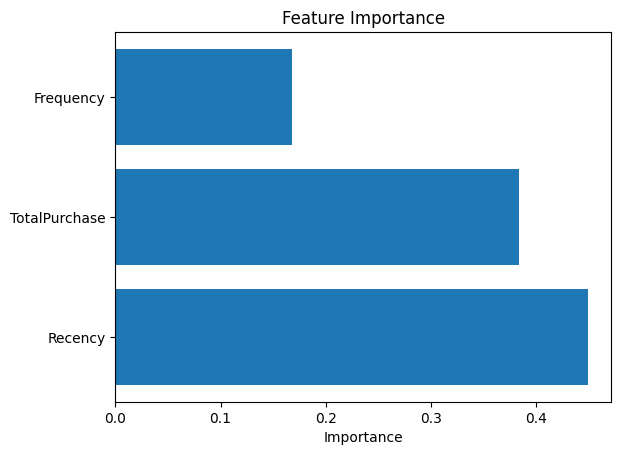

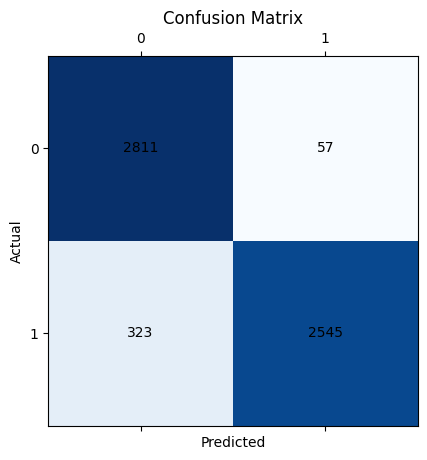

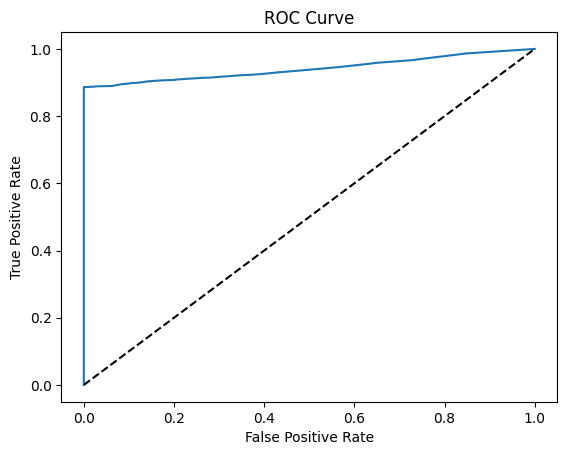

2024-05-24 18:20:16.332 | SUCCESS  | __main__:<module>:34 - Plots gemaakt


In [5]:
try:
    logger.info("Plots maken")

    # Feature Importance plot
    fig, ax = plt.subplots()
    ax.barh(feature_importances.index, feature_importances['importance'])
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance')
    plt.show()

    # Confusion Matrix plot
    fig, ax = plt.subplots()
    cm = confusion_matrix(y_test, y_pred)
    ax.matshow(cm, cmap='Blues')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    logger.success("Plots gemaakt")
except Exception as e:
    logger.error(f"Error: {e}")